# Movie Recommendation System using OpenAI Embeddings

### Importing Libraries

In [153]:
# Importing all the libraries
import openai
import os
from dotenv import load_dotenv
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [116]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wodnet')
# load the API Key
load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')
# Load the datasets
credits_df = pd.read_csv('tmdb_5000_credits.csv')
movies_df = pd.read_csv('tmdb_5000_movies.csv')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\balde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\balde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading wodnet: Package 'wodnet' not found in index


### Pre-processing

In [117]:
# Function to describe a dataset

def describe_dataset(df):
    """
    A Description of the entire dataset
    """
    # Display the first 5 rows of the dataset
    print("First 5 rows of the dataset:\n ")
    print(df.head(5))
    print("\n")

    # Display the basic information of the dataset
    print("Basic information: ")
    print(df.info())
    print("\n")

    # Display the shape of the dataset
    print("Shape of the dataset: ")
    print(df.shape)
    print("\n")

    # Display summary statistics of the dataset
    print("Summary Statistics: ")
    print(df.describe())
    print("\n")

    # Display teh number of missing values in the dataset
    print("Missing Values: ")
    print(df.isnull().sum())
    print("\n")

    # Display the number of unique values for each column
    print("Unique values:")
    for column in df.columns:
        unique_values = df[column].nunique()
        print(f"{column}:{unique_values} unique values")
    print("\n")

    # Display the datatypes of each column
    print("Datatypes: ")
    print(df.dtypes)
    print("\n")

    # Display the correlation matrix for each numerical feature
    print("Correlation Matrix: ")
    correlation_matrix = df.select_dtypes(include=['int64','float64']).corr()
    print(correlation_matrix)
    print("\n")

    # PLot the correlation matrix using a heatmap
    plt.figure(figsize=(12,8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.show()


First 5 rows of the dataset:
 
   movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_i

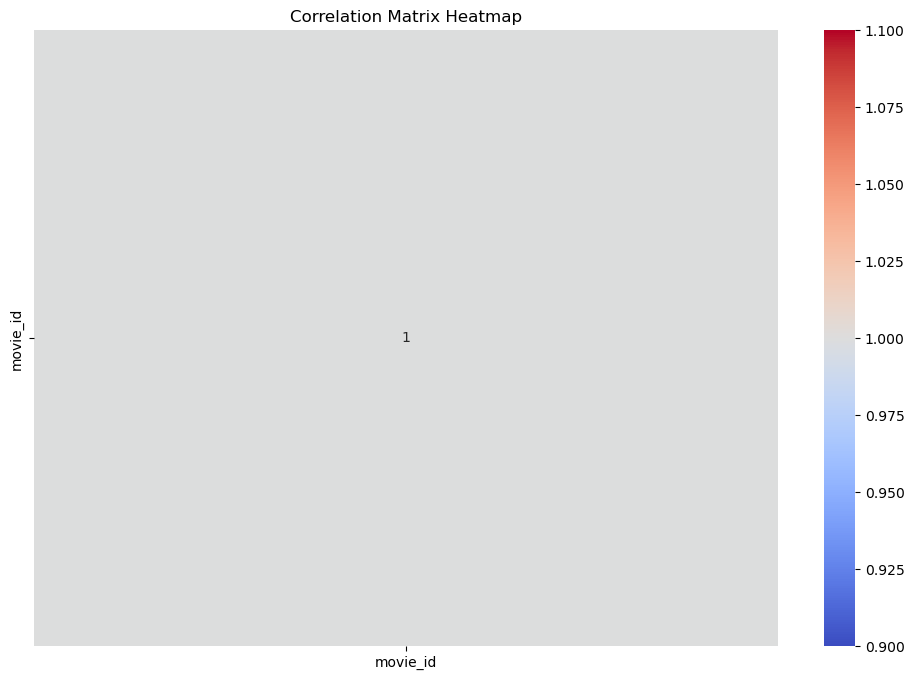

In [118]:
describe_dataset(credits_df)

First 5 rows of the dataset:
 
      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...           

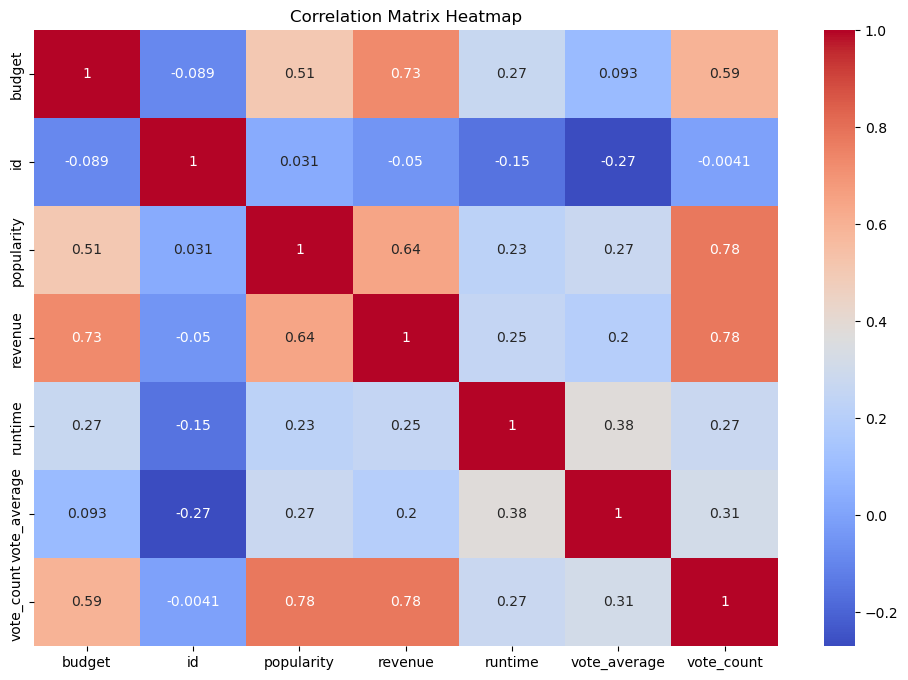

In [119]:
describe_dataset(movies_df)

The correlation map shows some features that are highly correlated with each other. Therefore, those will be dropped.

In [120]:
movies_df['runtime'].fillna(movies_df['runtime'].median(), inplace=True)

C:\Users\balde\AppData\Local\Temp\ipykernel_34572\1243963855.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df['runtime'].fillna(movies_df['runtime'].median(), inplace=True)


In [121]:
movies_df.dropna(subset=['overview','genres'],inplace=True)

In [122]:
movies_df = movies_df.merge(credits_df, left_on='id',right_on='movie_id',how='left')

In [123]:
# Extract Director//Writer
def extract_crew(crew, job):
    for member in crew:
        if member['job'] == job:
            return member['name']
    return None


movies_df['director'] = movies_df['crew'].apply(lambda x: extract_crew(ast.literal_eval(x),'Director'))

movies_df['director'].fillna('', inplace=True)

In [124]:
# Creating a function to tokenize, filter out the stopwords and lemmatize the text
def preprocess_text(text):
    if not isinstance(text,str):
        return ""
    
    tokens = word_tokenize(text) #Tokenize the text

    stop_words = set(stopwords.words('english')) # Setting the stop words
    filtered_tokens = [w for w in tokens if not w.lower() in stop_words] # Filtering out the stop words

    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w) for w in filtered_tokens])

    return lemmatized_text


In [125]:
 # Creating function to remove any '' marks surounding a list to evaluate it as a list instead of a string
def flatten_list(data_str):
    try:
        # Evaluate string as a list
        items = ast.literal_eval(data_str)
        names = [item['name'] for item in items]
        return ' '.join(names)
    except:
        return data_str


In [126]:
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew,director
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",James Cameron
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Gore Verbinski


In [127]:
# Dropping unnecessary features
movies_df.drop(['movie_id','id','homepage','tagline','status','original_language','popularity','spoken_languages','production_companies',
'production_countries','revenue','status','vote_average','vote_count','title_x','title_y','crew'],axis=1,inplace=True)

In [128]:
#  Preprocessing the required features by utilizing the previous two functions
def load_and_preprocess(df):
    list_columns = ['genres','cast','keywords']
    text_columns = ['original_title','overview','release_date','director','runtime','budget']

    for col in list_columns:
        df[col] = df[col].apply(lambda x: flatten_list(x)).apply(lambda x: preprocess_text(x))
    
    for col in text_columns:
        df[col] = df[col].apply(lambda x: preprocess_text(x))

    df['combined_features'] = df[list_columns + text_columns].apply(lambda row: ' '.join(row.values.astype(str)),axis=1)

    return df

In [129]:
df_movies = load_and_preprocess(movies_df)

In [130]:
df_movies.head(2)

,budget,genres,keywords,original_title,overview,release_date,runtime,cast,director,combined_features
0,,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Avatar,"22nd century , paraplegic Marine dispatched mo...",2009-12-10,,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron,Action Adventure Fantasy Science Fiction Sam W...
1,,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Pirates Caribbean : World 's End,"Captain Barbossa , long believed dead , come b...",2007-05-19,,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski,Adventure Fantasy Action Johnny Depp Orlando B...


In [131]:
print(movies_df.loc[0, 'combined_features'])  #Printing a combined feature

Action Adventure Fantasy Science Fiction Sam Worthington Zoe Saldana Sigourney Weaver Stephen Lang Michelle Rodriguez Giovanni Ribisi Joel David Moore CCH Pounder Wes Studi Laz Alonso Dileep Rao Matt Gerald Sean Anthony Moran Jason Whyte Scott Lawrence Kelly Kilgour James Patrick Pitt Sean Patrick Murphy Peter Dillon Kevin Dorman Kelson Henderson David Van Horn Jacob Tomuri Michael Blain-Rozgay Jon Curry Luke Hawker Woody Schultz Peter Mensah Sonia Yee Jahnel Curfman Ilram Choi Kyla Warren Lisa Roumain Debra Wilson Chris Mala Taylor Kibby Jodie Landau Julie Lamm Cullen B. Madden Joseph Brady Madden Frankie Torres Austin Wilson Sara Wilson Tamica Washington-Miller Lucy Briant Nathan Meister Gerry Blair Matthew Chamberlain Paul Yates Wray Wilson James Gaylyn Melvin Leno Clark III Carvon Futrell Brandon Jelkes Micah Moch Hanniyah Muhammad Christopher Nolen Christa Oliver April Marie Thomas Bravita A. Threatt Colin Bleasdale Mike Bodnar Matt Clayton Nicole Dionne Jamie Harrison Allan Henry

In [132]:
df_movies.info() # All the datatypes are the same.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   budget             4800 non-null   object
 1   genres             4800 non-null   object
 2   keywords           4800 non-null   object
 3   original_title     4800 non-null   object
 4   overview           4800 non-null   object
 5   release_date       4800 non-null   object
 6   runtime            4800 non-null   object
 7   cast               4800 non-null   object
 8   director           4800 non-null   object
 9   combined_features  4800 non-null   object
dtypes: object(10)
memory usage: 375.1+ KB


In [133]:
df_movies.head()

,budget,genres,keywords,original_title,overview,release_date,runtime,cast,director,combined_features
0,,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Avatar,"22nd century , paraplegic Marine dispatched mo...",2009-12-10,,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron,Action Adventure Fantasy Science Fiction Sam W...
1,,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Pirates Caribbean : World 's End,"Captain Barbossa , long believed dead , come b...",2007-05-19,,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski,Adventure Fantasy Action Johnny Depp Orlando B...
2,,Action Adventure Crime,spy based novel secret agent sequel mi6 britis...,Spectre,cryptic message Bond ’ past sends trail uncove...,2015-10-26,,Daniel Craig Christoph Waltz Léa Seydoux Ralph...,Sam Mendes,Action Adventure Crime Daniel Craig Christoph ...
3,,Action Crime Drama Thriller,dc comic crime fighter terrorist secret identi...,Dark Knight Rises,Following death District Attorney Harvey Dent ...,2012-07-16,,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan,Action Crime Drama Thriller Christian Bale Mic...
4,,Action Adventure Science Fiction,based novel mar medallion space travel princes...,John Carter,"John Carter war-weary , former military captai...",2012-03-07,,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton,Action Adventure Science Fiction Taylor Kitsch...


### Generating Embeddings

In [135]:
def generate_embeddings(texts, model = "text-embedding-ada-002"):
    """
    Generate embeddings for a list of texts using ada-002 model
    """
    embeddings = []
    for text in texts:
        response = openai.embeddings.create(
                model=model,
                input=text
        )
        embeddings.append(response.data[0].embedding)
    return np.array(embeddings)


### Cosine Similarity

In [136]:
def find_similar_movies(query_embedding, movie_embedding, movies_titles, top_n = 5):
    """
    Finds and returns the most similar movies based on cosine similarities
    """

    similarity_scores = cosine_similarity([query_embedding],movie_embedding)[0]
    top_indices = similarity_scores.argsort()[-top_n:][::-1]
    return [(movies_titles[i], similarity_scores[i]) for i in top_indices]

In [137]:
# Generate embeddings for all movies
movie_embeddings = generate_embeddings(df_movies['combined_features'])

In [138]:
movie_embeddings

array([[ 0.00335147, -0.02497159, -0.02536688, ..., -0.01409423,
        -0.01902857,  0.00061083],
       [-0.00530553, -0.02541989, -0.01727125, ..., -0.02285458,
        -0.00501058,  0.01034355],
       [-0.00741472, -0.00738797, -0.02306653, ..., -0.01913519,
        -0.01221523, -0.0025206 ],
       ...,
       [-0.0078109 , -0.03040969, -0.02036115, ..., -0.01179974,
        -0.02672662, -0.02564254],
       [-0.00144063, -0.00818575, -0.00547906, ..., -0.00878723,
        -0.00728697, -0.01569396],
       [-0.02181795, -0.02217117, -0.01145918, ..., -0.00701679,
        -0.01552797, -0.01426454]])

In [145]:
user_query = "I want to watch movies with Chris Evans in it"
query_embedding = generate_embeddings([user_query])[0]

# Find and print top 5 similar movies
similar_movies = find_similar_movies(query_embedding, movie_embeddings, df_movies['original_title'], top_n=5)
for title, score in similar_movies:
    print(f"{title}: Similarity Score = {score}")

London: Similarity Score = 0.8361038788803437
Captain America : First Avenger: Similarity Score = 0.8331596602556681
Cellular: Similarity Score = 0.827930199280378
Captain America : Civil War: Similarity Score = 0.823953774121286
Captain America : Winter Soldier: Similarity Score = 0.8223415993640266
